In [1]:
from pathlib import Path
import typing
import yaml
import pandas as pd
import numpy as np

In [2]:
import workingmem
import workingmem.model
from workingmem.task.SIR import SIRDataset, SIRConfig, SIRTokenizer

from best_worst_models import best_worst

In [8]:
# reg2c2ss = Path("../model_checkpoints/nxgusfzl").resolve()
# reg2c2 = Path("../model_checkpoints/b931g4g8").resolve()
# reg3c3 = Path("../model_checkpoints/8l957ug3").resolve()
# reg3c3_l25 = Path("../model_checkpoints/h0x7w7g3").resolve()
# # reg3c3_8dim = Path("../model_checkpoints/gsbkbheh").resolve()
# reg5c2 = Path("../model_checkpoints/1ohh210b").resolve()
# reg5c5 = Path("../model_checkpoints/2h3s5i1j").resolve()

# reg10c2 = Path("../model_checkpoints/roodafij").resolve()
# reg10c3 = Path("../model_checkpoints/hb5q5efm").resolve()
# reg10c4 = Path("../model_checkpoints/cxnz9utf").resolve()
# reg10c5 = Path("../model_checkpoints/dyh8frn6").resolve()
# reg10c6 = Path("../model_checkpoints/7w6njh78").resolve()

# reg100c2 = Path("../model_checkpoints/cbihadil").resolve()
# reg100c4 = Path("../model_checkpoints/4tr728x0").resolve()
# reg100c8 = Path("../model_checkpoints/l3x10vt6").resolve()
# reg100c16 = Path("../model_checkpoints/akw33l3m").resolve()
# reg100c32 = Path("../model_checkpoints/lr79zu1i").resolve()
# reg100c64 = Path("../model_checkpoints/iuh9nj9l").resolve()

td_0 = Path("../model_checkpoints/j3nhalg5/td0/").resolve()
td_0_5 = Path("../model_checkpoints/j3nhalg5/td0.5/").resolve()
td_1 = Path("../model_checkpoints/j3nhalg5/td1/").resolve()

n = 5
best_0s = [*best_worst(td_0, n)][:n]
best_0_5s = [*best_worst(td_0_5, n)][:n]
best_1s = [*best_worst(td_1, n)][:n]

# best_2_2, _ = best_worst(reg2c2)
# best_2_2ss, _ = best_worst(reg2c2ss)
# best_3_3, _ = best_worst(reg3c3)
# best_3_3_l25, _ = best_worst(reg3c3_l25)
# # best_3_3_8dim, _ = best_worst(reg3c3_8dim)

# best_5_2, _ = best_worst(reg5c2)
# best_5_5, _ = best_worst(reg5c5)

# best_10_2, _ = best_worst(reg10c2)
# best_10_3, _ = best_worst(reg10c3)
# best_10_4, _ = best_worst(reg10c4)
# best_10_5, _ = best_worst(reg10c5)
# best_10_6, _ = best_worst(reg10c6)

# best_100_2, _ = best_worst(reg100c2)
# best_100_4, _ = best_worst(reg100c4)
# best_100_8, _ = best_worst(reg100c8)
# best_100_16, _ = best_worst(reg100c16)
# best_100_32, _ = best_worst(reg100c32)
# best_100_64, _ = best_worst(reg100c64)

Best models: [(PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0/astral-sweep-10'), 0.9999666666666667), (PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0/expert-sweep-7'), 0.9999633333333333), (PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0/autumn-sweep-5'), 0.9999433333333333), (PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0/ancient-sweep-14'), 0.9999133333333333), (PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0/giddy-sweep-11'), 0.9998266666666666)]
Worst models: [(PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0/colorful-sweep-12'), 0.9998166666666667), (PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0/hardy-sweep-6'), 0.9997633333333333), (PosixPath('/oscar/data/frankmj/aalok/wm-c

In [9]:
# model_2_2 = workingmem.model.ModelWrapper(best_2_2)
# print(model_2_2.history[-1])
# model_2_2ss = workingmem.model.ModelWrapper(best_2_2ss)
# print(model_2_2ss.history[-1])
# model_3_3 = workingmem.model.ModelWrapper(best_3_3)
# print(model_3_3.history[-1])
# model_3_3_l25 = workingmem.model.ModelWrapper(best_3_3_l25)
# print(model_3_3_l25.history[-1])

# model_5_2 = workingmem.model.ModelWrapper(best_5_2)
# print(model_5_2.history[-1])
# model_5_5 = workingmem.model.ModelWrapper(best_5_5)
# print(model_5_5.history[-1])

# model_10_2 = workingmem.model.ModelWrapper(best_10_2)
# print(model_10_2.history[-1])
# model_10_3 = workingmem.model.ModelWrapper(best_10_3)
# print(model_10_3.history[-1])
# model_10_4 = workingmem.model.ModelWrapper(best_10_4)
# print(model_10_4.history[-1])
# model_10_5 = workingmem.model.ModelWrapper(best_10_5)
# print(model_10_5.history[-1])
# model_10_6 = workingmem.model.ModelWrapper(best_10_6)
# print(model_10_6.history[-1])

model_0s = [*map(workingmem.model.ModelWrapper, best_0s)]
model_0_5s = [*map(workingmem.model.ModelWrapper, best_0_5s)]
model_1s = [*map(workingmem.model.ModelWrapper, best_1s)]

loading model from checkpoint: /oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0/astral-sweep-10
any additional options passed via `ModelConfig` will be ingored!
	ModelConfig(from_pretrained=PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0/astral-sweep-10'), attn_only=True, n_layers=2, n_heads=2, n_ctx=1205, d_model=256, d_head=128, d_mlp=0, d_vocab=None, init_weights=True, seed=None, positional_embedding_type='rotary')
loading model from checkpoint: /oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0/expert-sweep-7
any additional options passed via `ModelConfig` will be ingored!
	ModelConfig(from_pretrained=PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0/expert-sweep-7'), attn_only=True, n_layers=2, n_heads=2, n_ctx=1205, d_model=256, d_head=128, d_mlp=0, d_vocab=None, init_weights=True, seed=None, positional_embedding_type='rotary')
loadin

Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda


loading model from checkpoint: /oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0/giddy-sweep-11
any additional options passed via `ModelConfig` will be ingored!
	ModelConfig(from_pretrained=PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0/giddy-sweep-11'), attn_only=True, n_layers=2, n_heads=2, n_ctx=1205, d_model=256, d_head=128, d_mlp=0, d_vocab=None, init_weights=True, seed=None, positional_embedding_type='rotary')
loading model from checkpoint: /oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0.5/azure-sweep-25
any additional options passed via `ModelConfig` will be ingored!
	ModelConfig(from_pretrained=PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0.5/azure-sweep-25'), attn_only=True, n_layers=2, n_heads=2, n_ctx=1205, d_model=256, d_head=128, d_mlp=0, d_vocab=None, init_weights=True, seed=None, positional_embedding_type='rotary')


Moving model to device:  cuda
Moving model to device:  cuda


loading model from checkpoint: /oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0.5/brisk-sweep-22
any additional options passed via `ModelConfig` will be ingored!
	ModelConfig(from_pretrained=PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0.5/brisk-sweep-22'), attn_only=True, n_layers=2, n_heads=2, n_ctx=1205, d_model=256, d_head=128, d_mlp=0, d_vocab=None, init_weights=True, seed=None, positional_embedding_type='rotary')
loading model from checkpoint: /oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0.5/sweepy-sweep-23
any additional options passed via `ModelConfig` will be ingored!
	ModelConfig(from_pretrained=PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0.5/sweepy-sweep-23'), attn_only=True, n_layers=2, n_heads=2, n_ctx=1205, d_model=256, d_head=128, d_mlp=0, d_vocab=None, init_weights=True, seed=None, positional_embedding_type='rotary'

Moving model to device:  cuda
Moving model to device:  cuda


loading model from checkpoint: /oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0.5/lemon-sweep-26
any additional options passed via `ModelConfig` will be ingored!
	ModelConfig(from_pretrained=PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0.5/lemon-sweep-26'), attn_only=True, n_layers=2, n_heads=2, n_ctx=1205, d_model=256, d_head=128, d_mlp=0, d_vocab=None, init_weights=True, seed=None, positional_embedding_type='rotary')
loading model from checkpoint: /oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0.5/gentle-sweep-30
any additional options passed via `ModelConfig` will be ingored!
	ModelConfig(from_pretrained=PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td0.5/gentle-sweep-30'), attn_only=True, n_layers=2, n_heads=2, n_ctx=1205, d_model=256, d_head=128, d_mlp=0, d_vocab=None, init_weights=True, seed=None, positional_embedding_type='rotary'

Moving model to device:  cuda
Moving model to device:  cuda


loading model from checkpoint: /oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td1/summer-sweep-41
any additional options passed via `ModelConfig` will be ingored!
	ModelConfig(from_pretrained=PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td1/summer-sweep-41'), attn_only=True, n_layers=2, n_heads=2, n_ctx=1205, d_model=256, d_head=128, d_mlp=0, d_vocab=None, init_weights=True, seed=None, positional_embedding_type='rotary')
loading model from checkpoint: /oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td1/misunderstood-sweep-36
any additional options passed via `ModelConfig` will be ingored!
	ModelConfig(from_pretrained=PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td1/misunderstood-sweep-36'), attn_only=True, n_layers=2, n_heads=2, n_ctx=1205, d_model=256, d_head=128, d_mlp=0, d_vocab=None, init_weights=True, seed=None, positional_embedding_type=

Moving model to device:  cuda
Moving model to device:  cuda


loading model from checkpoint: /oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td1/rosy-sweep-43
any additional options passed via `ModelConfig` will be ingored!
	ModelConfig(from_pretrained=PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td1/rosy-sweep-43'), attn_only=True, n_layers=2, n_heads=2, n_ctx=1205, d_model=256, d_head=128, d_mlp=0, d_vocab=None, init_weights=True, seed=None, positional_embedding_type='rotary')
loading model from checkpoint: /oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td1/summer-sweep-40
any additional options passed via `ModelConfig` will be ingored!
	ModelConfig(from_pretrained=PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td1/summer-sweep-40'), attn_only=True, n_layers=2, n_heads=2, n_ctx=1205, d_model=256, d_head=128, d_mlp=0, d_vocab=None, init_weights=True, seed=None, positional_embedding_type='rotary')


Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda


loading model from checkpoint: /oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td1/fragrant-sweep-44
any additional options passed via `ModelConfig` will be ingored!
	ModelConfig(from_pretrained=PosixPath('/oscar/data/frankmj/aalok/wm-computational-limits/model_checkpoints/j3nhalg5/td1/fragrant-sweep-44'), attn_only=True, n_layers=2, n_heads=2, n_ctx=1205, d_model=256, d_head=128, d_mlp=0, d_vocab=None, init_weights=True, seed=None, positional_embedding_type='rotary')


Moving model to device:  cuda


In [11]:
# dataset_100_2 = SIRDataset.from_path(
#     model_100_2.history[-1]["dataset_path"], split="test", generate=False
# )
# dataset_100_4 = SIRDataset.from_path(
#     model_100_4.history[-1]["dataset_path"], split="test", generate=False
# )
# dataset_100_8 = SIRDataset.from_path(
#     model_100_8.history[-1]["dataset_path"], split="test", generate=False
# )
# dataset_100_16 = SIRDataset.from_path(
#     model_100_16.history[-1]["dataset_path"], split="test", generate=False
# )
# dataset_100_32 = SIRDataset.from_path(
#     model_100_32.history[-1]["dataset_path"], split="test", generate=False
# )
# dataset_100_64 = SIRDataset.from_path(
#     model_100_64.history[-1]["dataset_path"], split="test", generate=False
# )

dataset_td0 = SIRDataset.from_path(
    model_0s[0].history[-1]["dataset_path"], split="test", generate=False
)
dataset_td0_5 = SIRDataset.from_path(
    model_0_5s[0].history[-1]["dataset_path"], split="test", generate=False
)
dataset_td1 = SIRDataset.from_path(
    model_1s[0].history[-1]["dataset_path"], split="test", generate=False
)

# # free up memory from models that failed to learn
# del model_100_32
# del model_100_64

datasets = [
    dataset_td0,
    dataset_td0_5,
    dataset_td1,
    # reg100 and length300 datasets
    # dataset_100_2,
    # dataset_100_4,
    # dataset_100_8,
    # dataset_100_16,
    # dataset_100_32,
    # dataset_100_64,
]
datasets

[SIRDataset_39A957_(concurrent_items=4,concurrent_reg=4,global_split_set_control=None,heldout_items=0,heldout_items_per_reg=15,heldout_reg=0,ignore_prob=0.5,load=True,local_split_set_control=None,locality=None,n_back=5,n_items=50,n_reg=50,n_test=1000,n_train=100000,n_val=1000,same_diff_prob=0.5,seed=None,seq_len=300,td_prob=0.0),
 SIRDataset_631B1C_(concurrent_items=4,concurrent_reg=4,global_split_set_control=None,heldout_items=0,heldout_items_per_reg=15,heldout_reg=0,ignore_prob=0.5,load=True,local_split_set_control=None,locality=None,n_back=5,n_items=50,n_reg=50,n_test=1000,n_train=100000,n_val=1000,same_diff_prob=0.5,seed=None,seq_len=300,td_prob=0.5),
 SIRDataset_ED20B7_(concurrent_items=4,concurrent_reg=4,global_split_set_control=None,heldout_items=0,heldout_items_per_reg=15,heldout_reg=0,ignore_prob=0.5,load=True,local_split_set_control=None,locality=None,n_back=5,n_items=50,n_reg=50,n_test=1000,n_train=100000,n_val=1000,same_diff_prob=0.5,seed=None,seq_len=300,td_prob=1.0)]

In [12]:
(
    dataset_td0.tokenizer.encode("St reg_5 item_1").ids,
    dataset_td1.tokenizer.encode("St reg_5 item_1").ids,
    dataset_td0_5.tokenizer.encode("St reg_5 item_1").ids,
)

([3, 105, 301], [3, 105, 301], [3, 105, 301])

In [13]:
table = []

for m, m_name in (
    [(model, "model_td0") for model in model_0s]
    + [(model, "model_td0.5") for model in model_0_5s]
    + [(model, "model_td1") for model in model_1s]
):
    print(m_name)
    for dataset in [
        dataset_td0,
        dataset_td0_5,
        dataset_td1,
    ]:
        try:
            out = m.test(dataset=dataset)
            loss, acc = out["loss"], out["acc"]
        except RuntimeError as e:
            print(f"Error evaluating {m_name} on {dataset}: {e}")
            continue
        table += [
            {
                "model": m_name,
                "dataset": f"{dataset}_{dataset.config.n_reg}_{dataset.config.concurrent_reg}_{dataset.config.seq_len}_ss{dataset.config.global_split_set_control}_td{dataset.config.td_prob}",
                "loss": loss,
                "acc": acc,
                "orig_acc": m.history[-1]["eval_acc"],
            }
        ]
        print(f"dataset: {repr(dataset)}")
        print("\tloss = %.3f, test_acc = %.3f" % (loss, acc))
    print("-" * 64)

model_td0
dataset: SIRDataset_39A957_(concurrent_items=4,concurrent_reg=4,global_split_set_control=None,heldout_items=0,heldout_items_per_reg=15,heldout_reg=0,ignore_prob=0.5,load=True,local_split_set_control=None,locality=None,n_back=5,n_items=50,n_reg=50,n_test=1000,n_train=100000,n_val=1000,same_diff_prob=0.5,seed=None,seq_len=300,td_prob=0.0)
	loss = 0.000, test_acc = 1.000
dataset: SIRDataset_631B1C_(concurrent_items=4,concurrent_reg=4,global_split_set_control=None,heldout_items=0,heldout_items_per_reg=15,heldout_reg=0,ignore_prob=0.5,load=True,local_split_set_control=None,locality=None,n_back=5,n_items=50,n_reg=50,n_test=1000,n_train=100000,n_val=1000,same_diff_prob=0.5,seed=None,seq_len=300,td_prob=0.5)
	loss = 0.002, test_acc = 1.000
dataset: SIRDataset_ED20B7_(concurrent_items=4,concurrent_reg=4,global_split_set_control=None,heldout_items=0,heldout_items_per_reg=15,heldout_reg=0,ignore_prob=0.5,load=True,local_split_set_control=None,locality=None,n_back=5,n_items=50,n_reg=50,n

In [14]:
df = pd.DataFrame(table)
df

,model,dataset,loss,acc,orig_acc
0,model_td0,SIRDataset_39A957_50_4_300_ssFalse_td0.0,0.000386,0.999893,0.999967
1,model_td0,SIRDataset_631B1C_50_4_300_ssFalse_td0.5,0.001941,0.999653,0.999967
2,model_td0,SIRDataset_ED20B7_50_4_300_ssFalse_td1.0,0.000271,0.999913,0.999967
3,model_td0,SIRDataset_39A957_50_4_300_ssFalse_td0.0,0.000174,0.999943,0.999963
4,model_td0,SIRDataset_631B1C_50_4_300_ssFalse_td0.5,0.000870,0.999807,0.999963
5,model_td0,SIRDataset_ED20B7_50_4_300_ssFalse_td1.0,0.000072,0.999977,0.999963
6,model_td0,SIRDataset_39A957_50_4_300_ssFalse_td0.0,0.000200,0.999940,0.999943
7,model_td0,SIRDataset_631B1C_50_4_300_ssFalse_td0.5,0.000980,0.999657,0.999943
8,model_td0,SIRDataset_ED20B7_50_4_300_ssFalse_td1.0,0.000067,0.999970,0.999943
9,model_td0,SIRDataset_39A957_50_4_300_ssFalse_td0.0,0.000353,0.999903,0.999913


In [15]:
df.tail(20)

,model,dataset,loss,acc,orig_acc
25,model_td0.5,SIRDataset_631B1C_50_4_300_ssFalse_td0.5,0.017326,0.992197,0.991127
26,model_td0.5,SIRDataset_ED20B7_50_4_300_ssFalse_td1.0,0.011144,0.995337,0.991127
27,model_td0.5,SIRDataset_39A957_50_4_300_ssFalse_td0.0,0.088335,0.955923,0.967960
28,model_td0.5,SIRDataset_631B1C_50_4_300_ssFalse_td0.5,0.071130,0.965187,0.967960
29,model_td0.5,SIRDataset_ED20B7_50_4_300_ssFalse_td1.0,0.046787,0.980147,0.967960
30,model_td1,SIRDataset_39A957_50_4_300_ssFalse_td0.0,2.860538,0.753707,0.999740
31,model_td1,SIRDataset_631B1C_50_4_300_ssFalse_td0.5,1.734128,0.844617,0.999740
32,model_td1,SIRDataset_ED20B7_50_4_300_ssFalse_td1.0,0.000981,0.999703,0.999740
33,model_td1,SIRDataset_39A957_50_4_300_ssFalse_td0.0,6.644910,0.626780,0.999690
34,model_td1,SIRDataset_631B1C_50_4_300_ssFalse_td0.5,4.213824,0.754107,0.999690


In [10]:
df.to_csv("best_worst_results.csv", index=False)

/tmp/ipykernel_2232955/3811749209.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


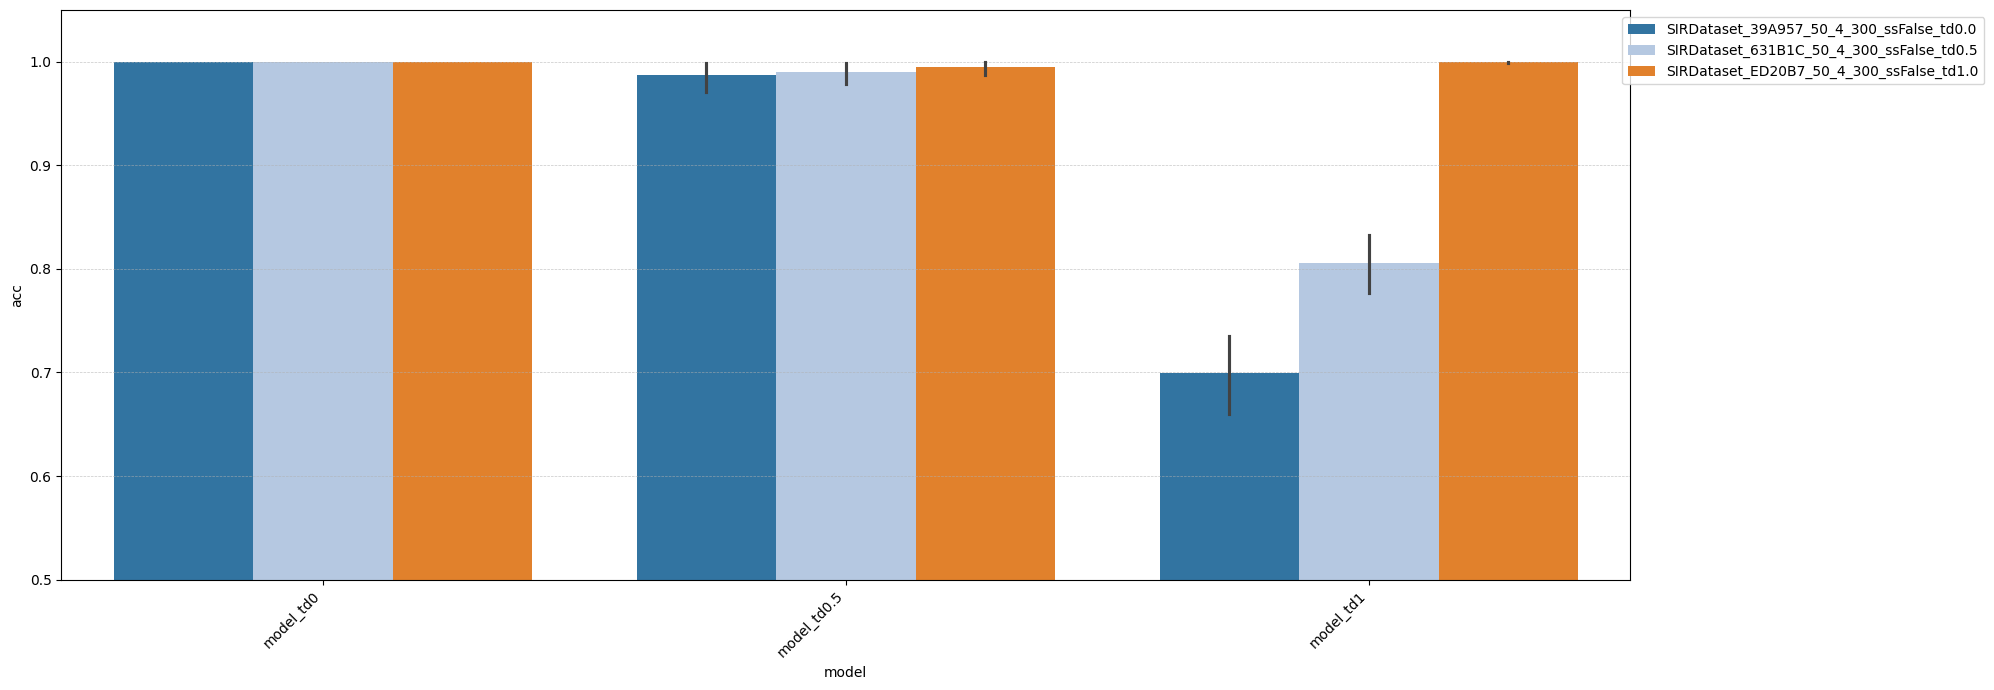

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

f, ax = plt.subplots(figsize=(20, 7))
sns.barplot(
    data=df,
    hue="dataset",
    y="acc",
    x="model",
    palette="tab20",
    alpha=1,
    dodge=True,
)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim(0.5, 1.05)
# set xtick rotation to 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# add the model eval performance % to xtick labels using the 'orig_acc' column of the dataframe

ax.grid(
    axis="y",
    linestyle="--",
    linewidth=0.5,
    alpha=0.7,
)
ax.legend(bbox_to_anchor=(1.23, 1), loc="upper right")
f.tight_layout()
plt.show()